# ETL of Crisis Figures Data

### First we will import modules and dependencies. Note that a .py file and assigned variable are used to access passwords that are stored locally, avoiding upload of passwords.

In [59]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import psycopg2
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import ols, logit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from statsmodels.graphics.mosaicplot import mosaic
from password import password

### Then we load our .csv data into a pandas dataframe for cleaning:

In [60]:
#create and examine dataframe
crisis_df = pd.read_csv("crisis_data.csv")
crisis_df

,crisis_index,crisis_name,crisis_iso3,figure_name,figure_source,figure_value,figure_date,figure_url
0,1,Afghanistan,AFG,People in Need,OCHA,24400000,2021-12-02,https://reliefweb.int/node/3796720
1,1,Afghanistan,AFG,People Targeted for Assistance,OCHA,22100000,2021-12-02,https://reliefweb.int/node/3796720
2,1,Afghanistan,AFG,Children in Need,UNICEF,12900000,2021-12-07,https://reliefweb.int/node/3798486
3,1,Afghanistan,AFG,People in Food Crisis/Emergency (IPC phase 3+),IPC,18844000,2021-10-25,https://reliefweb.int/node/3785295
4,1,Afghanistan,AFG,Undocumented Afghan Returnees from Iran (per y...,IOM,858956,2021-09-09,https://reliefweb.int/node/3775407
...,...,...,...,...,...,...,...,...
616,30,Zimbabwe,ZWE,Refugees & Asylum-Seekers in Zimbabwe,UNHCR,22600,2021-08-31,https://reliefweb.int/node/3778376
617,30,Zimbabwe,ZWE,DRC Refugees in Zimbabwe,UNHCR,12020,2021-08-31,https://reliefweb.int/node/3778376
618,30,Zimbabwe,ZWE,Mozambican Asylum-Seekers in Zimbabwe,UNHCR,8157,2021-08-31,https://reliefweb.int/node/3778376
619,30,Zimbabwe,ZWE,People Received WFP Food Assistance (per month),WFP,859182,2021-11-30,https://reliefweb.int/node/3802533


### The data is checked for NaNs and special characters, then sorted and organized.

In [61]:
#check for NaN or missing values
crisis_df.isnull().sum()

crisis_index     0
crisis_name      0
crisis_iso3      0
figure_name      0
figure_source    0
figure_value     0
figure_date      0
figure_url       0
dtype: int64

In [62]:
#replace commas in data so it won't mess with the data
crisis_df["figure_name"] = crisis_df["figure_name"].str.replace(",","")
crisis_df

,crisis_index,crisis_name,crisis_iso3,figure_name,figure_source,figure_value,figure_date,figure_url
0,1,Afghanistan,AFG,People in Need,OCHA,24400000,2021-12-02,https://reliefweb.int/node/3796720
1,1,Afghanistan,AFG,People Targeted for Assistance,OCHA,22100000,2021-12-02,https://reliefweb.int/node/3796720
2,1,Afghanistan,AFG,Children in Need,UNICEF,12900000,2021-12-07,https://reliefweb.int/node/3798486
3,1,Afghanistan,AFG,People in Food Crisis/Emergency (IPC phase 3+),IPC,18844000,2021-10-25,https://reliefweb.int/node/3785295
4,1,Afghanistan,AFG,Undocumented Afghan Returnees from Iran (per y...,IOM,858956,2021-09-09,https://reliefweb.int/node/3775407
...,...,...,...,...,...,...,...,...
616,30,Zimbabwe,ZWE,Refugees & Asylum-Seekers in Zimbabwe,UNHCR,22600,2021-08-31,https://reliefweb.int/node/3778376
617,30,Zimbabwe,ZWE,DRC Refugees in Zimbabwe,UNHCR,12020,2021-08-31,https://reliefweb.int/node/3778376
618,30,Zimbabwe,ZWE,Mozambican Asylum-Seekers in Zimbabwe,UNHCR,8157,2021-08-31,https://reliefweb.int/node/3778376
619,30,Zimbabwe,ZWE,People Received WFP Food Assistance (per month),WFP,859182,2021-11-30,https://reliefweb.int/node/3802533


In [63]:
#sort data and make new dataframes for each table we want:
crisis_countries_df = crisis_df[['crisis_name','crisis_index','crisis_iso3']]
crisis_countries_df = crisis_countries_df.drop_duplicates('crisis_name')
crisis_countries_df

,crisis_name,crisis_index,crisis_iso3
0,Afghanistan,1,AFG
19,Bangladesh,2,BGD
37,Burkina Faso,3,BFA
56,Burundi,4,BDI
62,Cameroon,5,CMR
84,Central African Republic,6,CAF
109,Chad,7,TCD
131,Colombia,8,COL
138,Democratic Republic of the Congo,9,COD
182,Ethiopia,10,ETH


In [64]:
#repeat process for each desired table
crisis_figures_df = crisis_df[['figure_name','figure_value','crisis_index']]
crisis_figures_df

,figure_name,figure_value,crisis_index
0,People in Need,24400000,1
1,People Targeted for Assistance,22100000,1
2,Children in Need,12900000,1
3,People in Food Crisis/Emergency (IPC phase 3+),18844000,1
4,Undocumented Afghan Returnees from Iran (per y...,858956,1
...,...,...,...
616,Refugees & Asylum-Seekers in Zimbabwe,22600,30
617,DRC Refugees in Zimbabwe,12020,30
618,Mozambican Asylum-Seekers in Zimbabwe,8157,30
619,People Received WFP Food Assistance (per month),859182,30


In [65]:
figures_sources_df = crisis_df[['figure_source','figure_date','figure_name']]
figures_sources_df

,figure_source,figure_date,figure_name
0,OCHA,2021-12-02,People in Need
1,OCHA,2021-12-02,People Targeted for Assistance
2,UNICEF,2021-12-07,Children in Need
3,IPC,2021-10-25,People in Food Crisis/Emergency (IPC phase 3+)
4,IOM,2021-09-09,Undocumented Afghan Returnees from Iran (per y...
...,...,...,...
616,UNHCR,2021-08-31,Refugees & Asylum-Seekers in Zimbabwe
617,UNHCR,2021-08-31,DRC Refugees in Zimbabwe
618,UNHCR,2021-08-31,Mozambican Asylum-Seekers in Zimbabwe
619,WFP,2021-11-30,People Received WFP Food Assistance (per month)


### Now we can transfer the organized data from python to PostgreSQL database with a psycopg2 connection. 

In [66]:
# convert all DataFrames into .csv files for loading into Postgres:
crisis_countries_df.to_csv('crisis_countries.csv', index= False)
crisis_figures_df.to_csv('crisis_figures.csv', index= False)
figures_sources_df.to_csv('figures_sources.csv', index= False)


In [98]:
#in PostgreSQL, create a new database named project_2 to add new table to, and use psycopg2 to connect to it
conn = psycopg2.connect(dbname='project_2', user='postgres', password=password)
#create a cursor object to perform database operations
cursor= conn.cursor()

### Below, we create a series of queries to create and populate database tables.

In [68]:
#command to create a table
cursor.execute("DROP TABLE IF EXISTS crisis_countries")
table1=("""CREATE TABLE crisis_countries(
	crisis_name text,
	crisis_index integer,
	crisis_iso3 text
    )""")
#execute command
cursor.execute(table1)

I learned about this error while working the above cell: 

InFailedSqlTransaction                    Traceback (most recent call last)
~\AppData\Local\Temp/ipykernel_6804/1594995371.py in <module>
      1 #create query to create a table
----> 2 cursor.execute("DROP TABLE IF EXISTS crisis_countries")
      3 query=("""CREATE TABLE crisis_countries(
      4         crisis_index integer,
      5         crisis_name text,

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block
    
It happened because I had a syntax error in my query. I fixed it and ran the cell again. Because I used the same connection, SQL thinks it needs to keep me from spamming it with bad queries. I had to restart kernel and make a new connection with Postgres.


In [69]:
#use copy from to input values from csv into postgres table
with open('crisis_countries.csv', 'r') as f:
    next(f) # Skip the header row.
    cursor.copy_from(f, 'crisis_countries', sep=',')

In [70]:
#commit the table
conn.commit()

In [71]:
cursor.execute("DROP TABLE IF EXISTS crisis_figures")
table2=("""CREATE TABLE crisis_figures(
	figure_name text,
	figure_value integer,
	crisis_index integer
    )""")
cursor.execute(table2)

In [72]:
with open('crisis_figures.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'crisis_figures', sep=',')

In [73]:
conn.commit()

In [74]:
cursor.execute("DROP TABLE IF EXISTS figures_sources")
table3=("""CREATE TABLE figures_sources(
	figure_source text,
	figure_date varchar,
	figure_name text
    )""")
cursor.execute(table3)

In [75]:
with open('figures_sources.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'figures_sources', sep=',')

conn.commit()

# Our python data has been extracted, transformed, and loaded into a SQL database within PostgreSQL. 
# Now the data can be explored with SQL queries executed in python. See the examples below:

### First are three queries examining the data tables in the database:

In [76]:
# Select *
# From crisis_countries

In [77]:
query1 = "SELECT * FROM crisis_countries"

In [78]:
# execute the query programatically from this notebook:
cursor.execute(query1)

# get and store the results of the query as a variable
results_query1 = cursor.fetchall()

#display the results in this notebook as a pandas dataframe:
query1_df = pd.DataFrame(results_query1, columns = ['crisis_name', 'crisis_index', 'crisis_iso3'])
query1_df

,crisis_name,crisis_index,crisis_iso3
0,Afghanistan,1,AFG
1,Bangladesh,2,BGD
2,Burkina Faso,3,BFA
3,Burundi,4,BDI
4,Cameroon,5,CMR
5,Central African Republic,6,CAF
6,Chad,7,TCD
7,Colombia,8,COL
8,Democratic Republic of the Congo,9,COD
9,Ethiopia,10,ETH


In [79]:
# Select *
# From crisis_figures

In [80]:
query2 = "SELECT * FROM crisis_figures"

In [81]:
# execute the query programatically from this notebook:
cursor.execute(query2)

# get and store the results of the query as a variable
results_query2 = cursor.fetchall()

#display the results in this notebook as a pandas dataframe:
query2_df = pd.DataFrame(results_query2, columns = ['figure_name', 'figure_value', 'crisis_index'])
query2_df

,figure_name,figure_value,crisis_index
0,People in Need,24400000,1
1,People Targeted for Assistance,22100000,1
2,Children in Need,12900000,1
3,People in Food Crisis/Emergency (IPC phase 3+),18844000,1
4,Undocumented Afghan Returnees from Iran (per y...,858956,1
...,...,...,...
616,Refugees & Asylum-Seekers in Zimbabwe,22600,30
617,DRC Refugees in Zimbabwe,12020,30
618,Mozambican Asylum-Seekers in Zimbabwe,8157,30
619,People Received WFP Food Assistance (per month),859182,30


In [82]:
# Select *
# From figures_sources

In [83]:
query3 = "SELECT * FROM figures_sources"

In [84]:
# execute the query programatically from this notebook:
cursor.execute(query3)

# get and store the results of the query as a variable
results_query3 = cursor.fetchall()

#display the results in this notebook as a pandas dataframe:
query3_df = pd.DataFrame(results_query3, columns = ["figure_source", 'figure_date', 'figure_name'])
query3_df

,figure_source,figure_date,figure_name
0,OCHA,2021-12-02,People in Need
1,OCHA,2021-12-02,People Targeted for Assistance
2,UNICEF,2021-12-07,Children in Need
3,IPC,2021-10-25,People in Food Crisis/Emergency (IPC phase 3+)
4,IOM,2021-09-09,Undocumented Afghan Returnees from Iran (per y...
...,...,...,...
616,UNHCR,2021-08-31,Refugees & Asylum-Seekers in Zimbabwe
617,UNHCR,2021-08-31,DRC Refugees in Zimbabwe
618,UNHCR,2021-08-31,Mozambican Asylum-Seekers in Zimbabwe
619,WFP,2021-11-30,People Received WFP Food Assistance (per month)


### Here are five queries to perform more complex tasks with the data, including joining tables.

In [ ]:
# Display the name and figure value of the country that has the most children in need.

# SELECT crisis_name, MAX(figure_value) as number_of_children
# FROM crisis_countries as c
# INNER JOIN crisis_figures as f
# ON f.crisis_index = c.crisis_index
# WHERE figure_name = 'Children in Need'
# GROUP BY crisis_name
# ORDER BY number_of_children DESC
# LIMIT 1

In [85]:
query4 = "SELECT crisis_name, MAX(figure_value) as number_of_children FROM crisis_countries as c INNER JOIN crisis_figures as f ON f.crisis_index = c.crisis_index WHERE figure_name = 'Children in Need' GROUP BY crisis_name ORDER BY number_of_children DESC LIMIT 1"

In [86]:
# execute the query programatically from this notebook:
cursor.execute(query4)

# get and store the results of the query as a variable
results_query4 = cursor.fetchall()

#display the results in this notebook as a pandas dataframe:
query4_df = pd.DataFrame(results_query4, columns = ["crisis_name", 'number_of_children'])
query4_df

,crisis_name,number_of_children
0,Ethiopia,14000000


In [ ]:
# Display the source that provides the most figures for Yemen and how many figures it provides.

# SELECT crisis_name, figure_source as source, COUNT(figure_source) as number_of_figures
# FROM crisis_countries as c
# JOIN crisis_figures as f
# ON f.crisis_index = c.crisis_index
# JOIN figures_sources as s
# ON s.figure_name = f.figure_name
# WHERE crisis_name = 'Yemen'
# GROUP BY crisis_name, source
# ORDER BY number_of_figures DESC
# LIMIT 1

In [91]:
query5 = "SELECT crisis_name as country, figure_source as source, COUNT(figure_source) as number_of_figures FROM crisis_countries as c JOIN crisis_figures as f ON f.crisis_index = c.crisis_index JOIN figures_sources as s ON s.figure_name = f.figure_name WHERE crisis_name = 'Yemen' GROUP BY crisis_name, source ORDER BY number_of_figures DESC LIMIT 1"

In [92]:
# execute the query programatically from this notebook:
cursor.execute(query5)

# get and store the results of the query as a variable
results_query5 = cursor.fetchall()

#display the results in this notebook as a pandas dataframe:
query5_df = pd.DataFrame(results_query5, columns = ["country", 'source', 'number_of_figures'])
query5_df

,country,source,number_of_figures
0,Yemen,OCHA,61


In [ ]:
# Show how many acutely malnourished pregnant and lactating women are in Burkina Faso.

# SELECT crisis_name as country, figure_value as number_of_women
# FROM crisis_figures as f
# INNER JOIN crisis_countries as c
# ON c.crisis_index = f.crisis_index
# WHERE crisis_name = 'Burkina Faso' and figure_name = 'Pregnant or Lactating Women Acutely Malnourished'

In [89]:
query6 = "SELECT crisis_name as country, figure_value as number_of_women FROM crisis_figures as f INNER JOIN crisis_countries as c ON c.crisis_index = f.crisis_index WHERE crisis_name = 'Burkina Faso' and figure_name = 'Pregnant or Lactating Women Acutely Malnourished'"

In [90]:
# execute the query programatically from this notebook:
cursor.execute(query6)

# get and store the results of the query as a variable
results_query6 = cursor.fetchall()

#display the results in this notebook as a pandas dataframe:
query6_df = pd.DataFrame(results_query6, columns = ["country", 'number_of_women'])
query6_df

,country,number_of_women
0,Burkina Faso,128672


In [ ]:
# How many people targeted for assistance were reported in June and July 2021?

# Select SUM(figure_value) as people_targeted_for_assistance
# From crisis_figures as f
# JOIN figures_sources as s
# ON s.figure_name = f.figure_name
# WHERE s.figure_name = 'People Targeted for Assistance' 
# 	OR f.figure_name = 'People Targeted for Assistance' 
# 	AND figure_date BETWEEN '2021-05-31' AND '2021-07-31'

In [93]:
query7 = "Select SUM(figure_value) as people_targeted_for_assistance From crisis_figures as f JOIN figures_sources as s ON s.figure_name = f.figure_name WHERE s.figure_name = 'People Targeted for Assistance' OR f.figure_name = 'People Targeted for Assistance' AND figure_date BETWEEN '2021-05-31' AND '2021-07-31'"

In [94]:
# execute the query programatically from this notebook:
cursor.execute(query7)

# get and store the results of the query as a variable
results_query7 = cursor.fetchall()

#display the results in this notebook as a pandas dataframe:
query7_df = pd.DataFrame(results_query7, columns = ["people_targeted_for_assistance"])
query7_df

,people_targeted_for_assistance
0,4234599000


In [ ]:
# Which are the three countries with the most people affected by humanitarian crises?

# Select crisis_name as country, SUM(figure_value) as people_affected
# From crisis_countries as c
# JOIN crisis_figures as f
# ON f.crisis_index = c.crisis_index
# GROUP BY country
# ORDER BY people_affected DESC
# LIMIT 3

In [96]:
query8 = "Select crisis_name as country, SUM(figure_value) as people_affected From crisis_countries as c JOIN crisis_figures as f ON f.crisis_index = c.crisis_index GROUP BY country ORDER BY people_affected DESC LIMIT 3"

In [99]:
# execute the query programatically from this notebook:
cursor.execute(query8)

# get and store the results of the query as a variable
results_query8 = cursor.fetchall()

#display the results in this notebook as a pandas dataframe:
query8_df = pd.DataFrame(results_query8, columns = ["country", 'people_affected'])
query8_df

,country,people_affected
0,Yemen,96649039
1,Democratic Republic of the Congo,96371805
2,Ethiopia,95984105


In [100]:
# closing the connection with the database and closing the cursor object:

conn.close()
cursor.close()

# Data Model

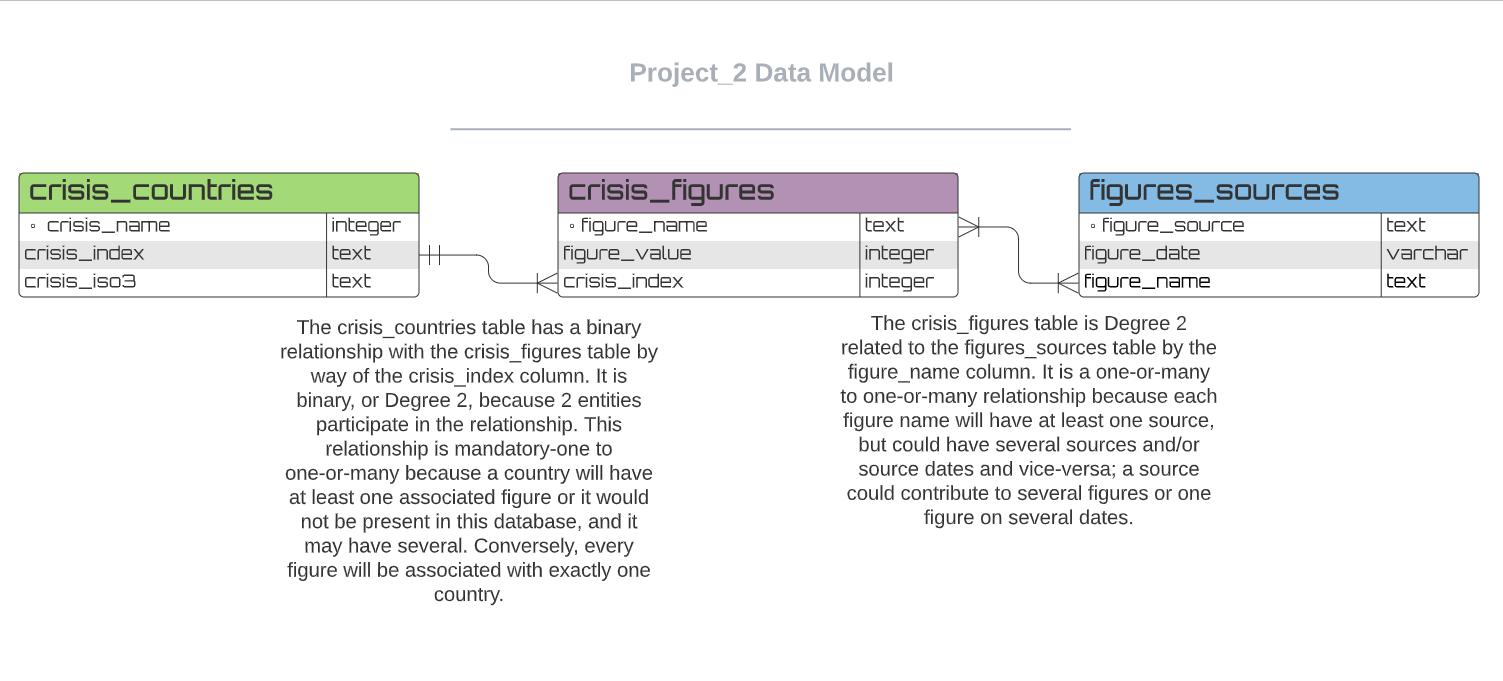